# Posprocessing a run

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%env XLA_PYTHON_CLIENT_MEM_FRACTION=.6

env: XLA_PYTHON_CLIENT_MEM_FRACTION=.6


In [3]:
import lenses
import jax
from jax import numpy as jnp
from typing import cast
import matplotlib.pyplot as plt

from flox.util import key_chain
from flox.flow import Pipe, Inverted, bind
from functools import partial
import equinox as eqx

from rigid_flows.flow import build_flow, RigidWithAuxiliary
from rigid_flows.data import Data, DataWithAuxiliary
from rigid_flows.density import OpenMMDensity
from rigid_flows.specs import FlowSpecification, CouplingSpecification, ExperimentSpecification
# from rigid_flows.density import PositionPrior, RotationPrior
from rigid_flows.utils import jit_and_cleanup_cache, scanned_vmap

chain = key_chain(42)

def count_params(model):
    return jax.tree_util.tree_reduce(
        lambda s, n: s + n.size if eqx.is_array(n) else s, model, jnp.zeros((), dtype=jnp.int32)).item()

2023-01-24 17:10:44.161044: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-24 17:10:44.161140: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/mi/minvernizzi/.local/lib
2023-01-24 17:10:44.161148: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


In [4]:
logdir_path = 'jonas_logdir/'
logdir_path += 'tuna_N16_T100_noaux_2023-01-24_16:02:39'
stage = 0
epoch = 9
print(f'+++ epoch {epoch} +++')
specs_path = f"{logdir_path}/config.yaml"
pretrained_model_path = f'{logdir_path}/training_stage_{stage}/epoch_{epoch}/model.eqx'


specs = ExperimentSpecification.load_from_file(specs_path)
specs = lenses.bind(specs).model.base.path.set(specs.model.base.path+'/eval_100')

base = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.base)
target = OpenMMDensity.from_specs(specs.model.auxiliary_shape, specs.model.target)
model = base.omm_model.model

data = Data.from_specs(specs.model.target, target.box)
flow = build_flow(next(chain), specs.model.auxiliary_shape, specs.model.flow)
flow = cast(Pipe[DataWithAuxiliary, RigidWithAuxiliary], eqx.tree_deserialise_leaves(pretrained_model_path, flow))

training_data_size = 100_000 if specs.model.base.num_samples is None else specs.model.base.num_samples
print(f'tot flow parameters: {count_params(flow):_}')
print(f'MD training datapoints = {training_data_size:_}')
print(f'MD eval datapoints = {base.data.pos.shape[0]:_}')
print(f'batchs per epoch = {specs.train[0].num_iters_per_epoch}')
print(f'batch size = {specs.train[0].num_samples}')
print(f'data fraction: {specs.train[0].num_epochs*specs.train[0].num_samples*specs.train[0].num_iters_per_epoch/training_data_size}')

+++ epoch 9 +++
tot flow parameters: 319_568
MD training datapoints = 100_000
MD eval datapoints = 100_000
batchs per epoch = 500
batch size = 32
data fraction: 1.6


In [5]:
def ess(logw):
    return jnp.exp(2*jax.scipy.special.logsumexp(logw)-jax.scipy.special.logsumexp(2*logw))

def plot_2Dview(data_tr: DataWithAuxiliary, title: str, toPBC: bool = True, skip: int = 10):
    model.plot_2Dview(data_tr.obj.pos.reshape(-1, model.n_atoms, 3), toPBC=toPBC, title=title)

hist_kwargs = {"bins": "auto", "density": True, "alpha": 0.5}

In [6]:
reference_deltaF, reference_deltaF_std = None, None

if specs.model.base.temperature == specs.model.target.temperature:
    reference_deltaF, reference_deltaF_std = 0, 0
elif specs.model.base.num_molecules == 16:
    if specs.model.base.temperature == 250 and specs.model.target.temperature == 100:
        reference_deltaF, reference_deltaF_std = -666.09897990553, 0.0558899 # MBAR, 10_000 samples, 5 replicas
    elif specs.model.base.temperature == 250 and specs.model.target.temperature == 50:
        reference_deltaF, reference_deltaF_std = -1818.2199636389134, 0.0632776 # MBAR, 10_000 samples, 10 replicas
elif specs.model.base.num_molecules == 128:
    if specs.model.base.temperature == 250 and specs.model.target.temperature == 100:
        reference_deltaF, reference_deltaF_std = -5314.324317927606, 0.0944014 # MBAR, 10_000 samples, 10 replicas
    elif specs.model.base.temperature == 250 and specs.model.target.temperature == 50:
        reference_deltaF, reference_deltaF_std = -14522.10556489954, 0.135 # MBAR, 10_000 samples, 20 replicas

reference_deltaF, reference_deltaF_std

(-666.09897990553, 0.0558899)

sampling base
mapping
getting logw


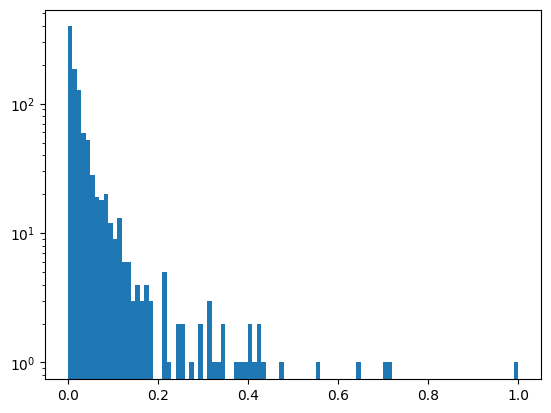

ESS = 195.228  ->  19.52%


In [7]:
num_samples = 1_000
batch_size = 128

print('sampling base')
keys = jax.random.split(next(chain), num_samples)
base_tr = jax.vmap(base.sample)(keys)

print('mapping')
mapped_tr = scanned_vmap(flow.forward, batch_size)(base_tr.obj)

print('getting logw')
## NB: base_tr.ldj = jax.vmap(base.potential)(base_tr.obj)
logw = base_tr.ldj + mapped_tr.ldj - jax.vmap(target.potential)(mapped_tr.obj)

plt.hist(jnp.exp(logw-logw.max()), bins=100)
plt.yscale('log')
plt.show()

print(f'ESS = {ess(logw):g}  ->  {ess(logw)/len(logw):.2%}')


sampling target
mapping
getting logw


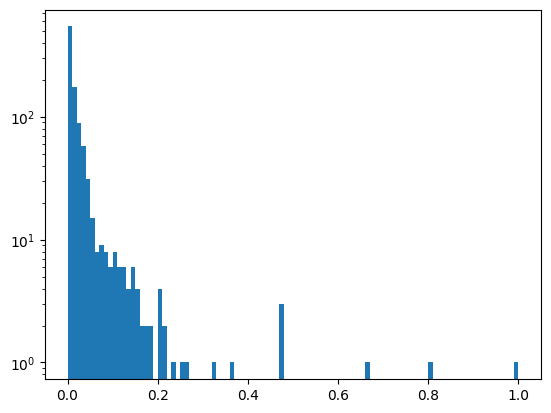

ESS = 137.511  ->  13.75%


In [8]:
print('sampling target')
keys = jax.random.split(next(chain), num_samples)
target_tr = jax.vmap(target.sample)(keys)

print('mapping')
back_mapped_tr = scanned_vmap(flow.inverse, batch_size)(target_tr.obj)

print('getting logw')
## NB: base_tr.ldj = jax.vmap(base.potential)(base_tr.obj)
back_logw = target_tr.ldj + back_mapped_tr.ldj - jax.vmap(base.potential)(back_mapped_tr.obj)

plt.hist(jnp.exp(back_logw - back_logw.max()), bins=100)
plt.yscale('log')
plt.show()

print(f'ESS = {ess(back_logw):g}  ->  {ess(back_logw)/len(back_logw):.2%}')

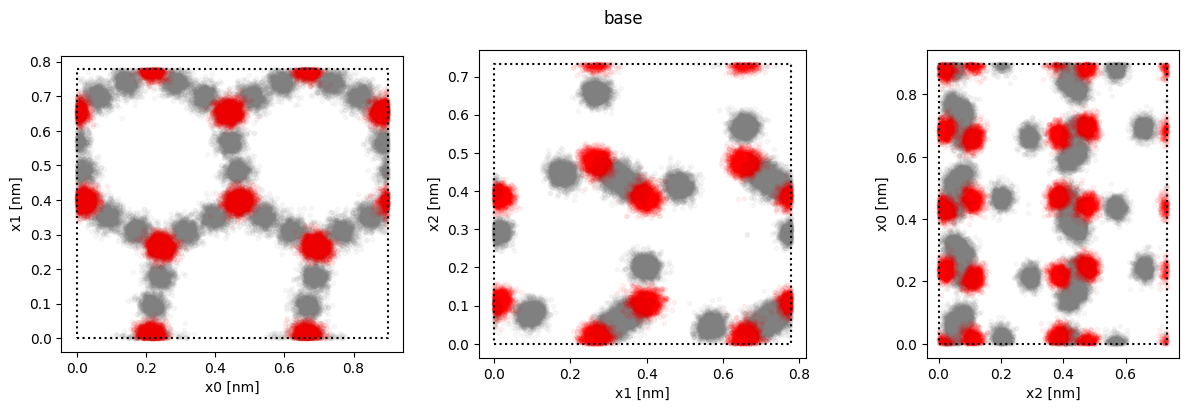

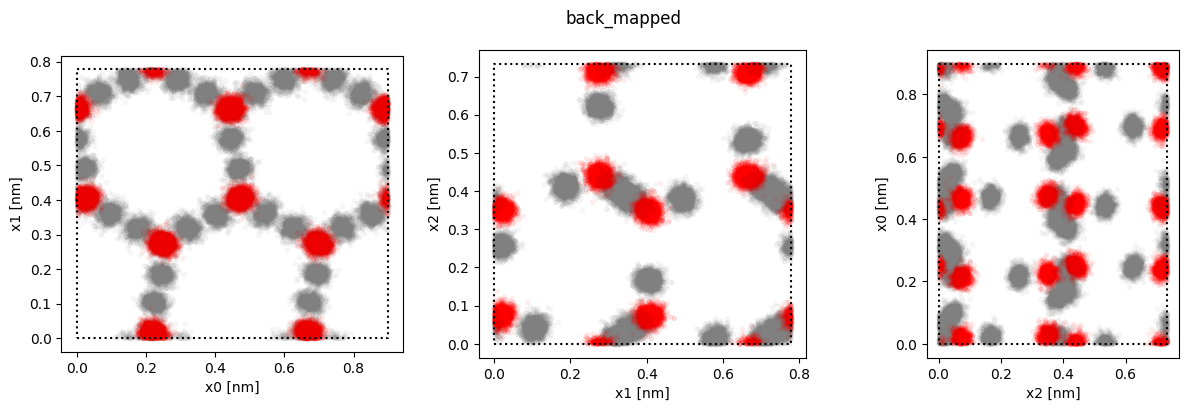

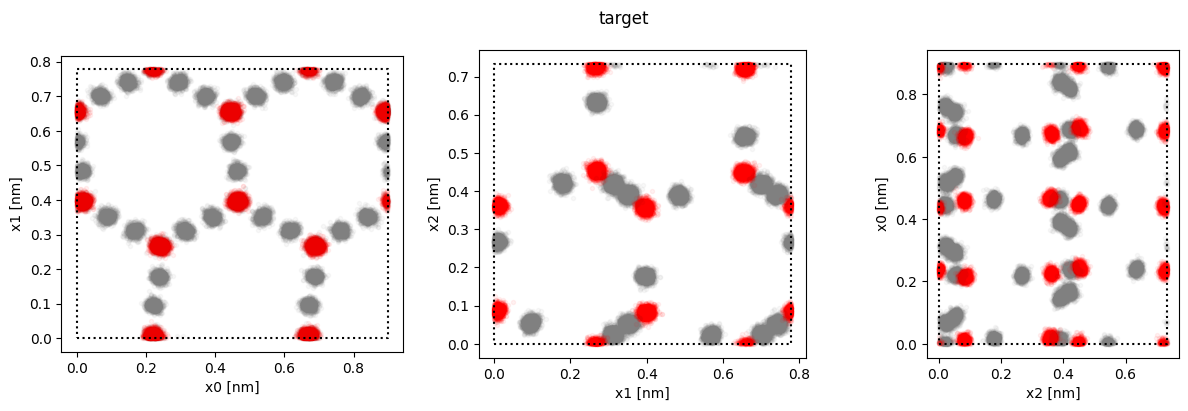

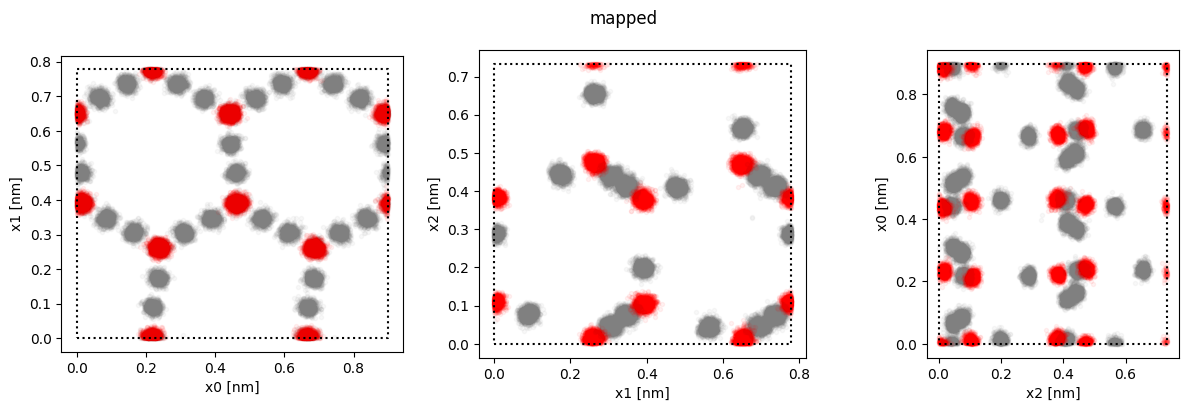

In [9]:
plot_2Dview(base_tr, title='base')
plot_2Dview(back_mapped_tr, title='back_mapped')

plot_2Dview(target_tr, title='target')
plot_2Dview(mapped_tr, title='mapped')

In [10]:
ene_label = 'omm'
scaling = 1
if ene_label == 'omm':
    scaling = target.omm_model.kbT
base_ene2 = target.compute_energies(base_tr.obj, True, False, True)[ene_label] * scaling
target_ene2 = target.compute_energies(target_tr.obj, True, False, True)[ene_label] * scaling
mapped_ene2 = target.compute_energies(mapped_tr.obj, True, False, True)[ene_label] * scaling
back_mapped_ene2 = target.compute_energies(back_mapped_tr.obj, True, False, True)[ene_label] * scaling

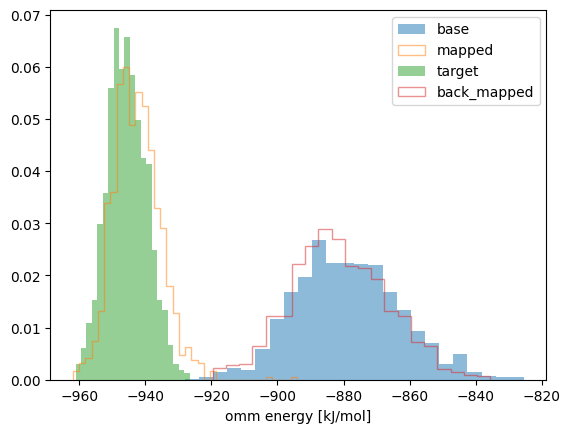

In [11]:
plt.hist(base_ene2, **hist_kwargs, label='base')
plt.hist(mapped_ene2, **hist_kwargs, label='mapped', histtype='step')
plt.hist(target_ene2, **hist_kwargs, label='target')
plt.hist(back_mapped_ene2, **hist_kwargs, label='back_mapped', histtype='step')
# plt.hist(mapped_ene2, weights=jnp.exp(logw-jax.scipy.special.logsumexp(logw)), bins=75, histtype='step', density=True, label='reweighted')
plt.xlabel(ene_label + ' energy [kJ/mol]') #it's kJ/mol only for omm energies
plt.legend()
plt.show()

In [12]:
## LFEP

deltaF = (jnp.log(len(logw)) - jax.scipy.special.logsumexp(logw)).item()
print(f'Estimated deltaF from base   (above) = {deltaF:g}')

back_deltaF = -(jnp.log(len(back_logw)) - jax.scipy.special.logsumexp(back_logw)).item()
print(f'Estimated deltaF from target (below) = {back_deltaF:g}')

if reference_deltaF is not None:
    print(f'               Reference MBAR deltaF = {reference_deltaF:g}')

Estimated deltaF from base   (above) = -664.614
Estimated deltaF from target (below) = -664.647
               Reference MBAR deltaF = -666.099


## compute LBAR

In [13]:
N_k = np.array([mapped_tr.obj.pos.shape[0], back_mapped_tr.obj.pos.shape[0]])

u_kn = np.empty((2, N_k.sum()))
u_kn[0] = np.concatenate([target_tr.ldj, base_tr.ldj - logw])
u_kn[1] = np.concatenate([target_tr.ldj - back_logw, base_tr.ldj])

N_k.shape, u_kn.shape

((2,), (2, 2000))

In [14]:
import pymbar

mbar = pymbar.MBAR(u_kn, N_k, n_bootstraps=100, solver_protocol='robust')
# mbar = pymbar.MBAR(u_kn, N_k, n_bootstraps=100)

In [15]:
results = mbar.compute_free_energy_differences(uncertainty_method="bootstrap")

print(f"DeltaF = {results['Delta_f'][-1,0]} +/- {results['dDelta_f'][-1,0]:g}")

DeltaF = -664.684561574536 +/- 0.0296994
